# FieldMesh Examples

In [1]:
from pmd_beamphysics import FieldMesh, tools


import numpy as np
# Nicer plotting
import matplotlib.pyplot as plt

In [2]:
FM = FieldMesh('../data/solenoid.h5')
FM.geometry

'cylindrical'

Built-in plotting:

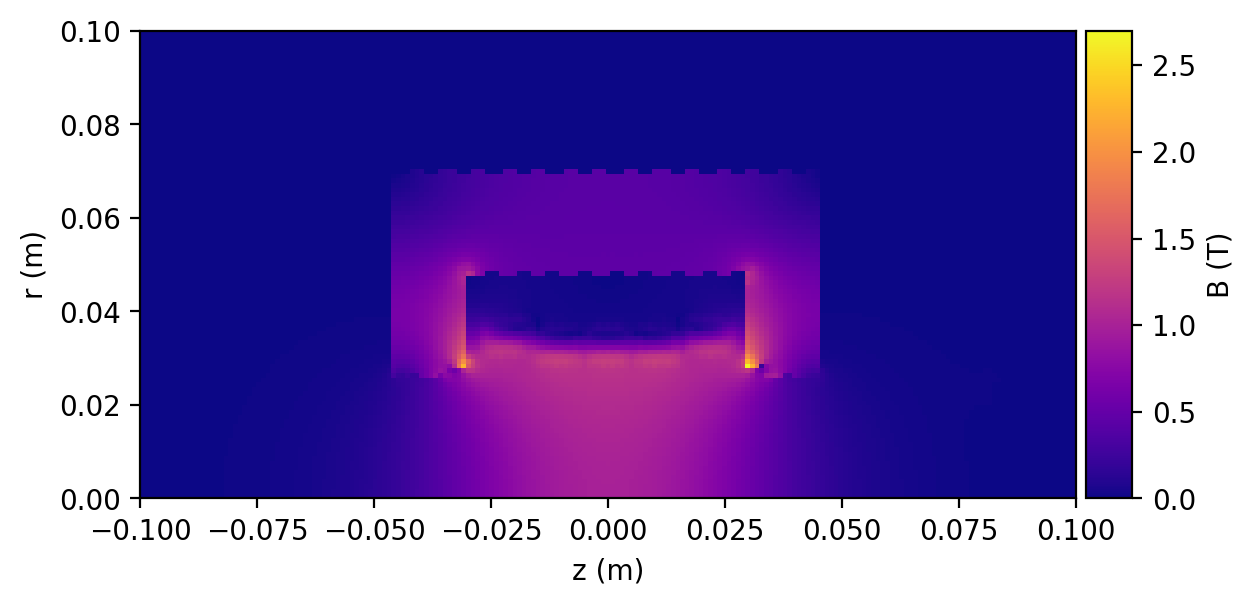

In [3]:
FM.plot('B', aspect='equal')

On-axis field plotting

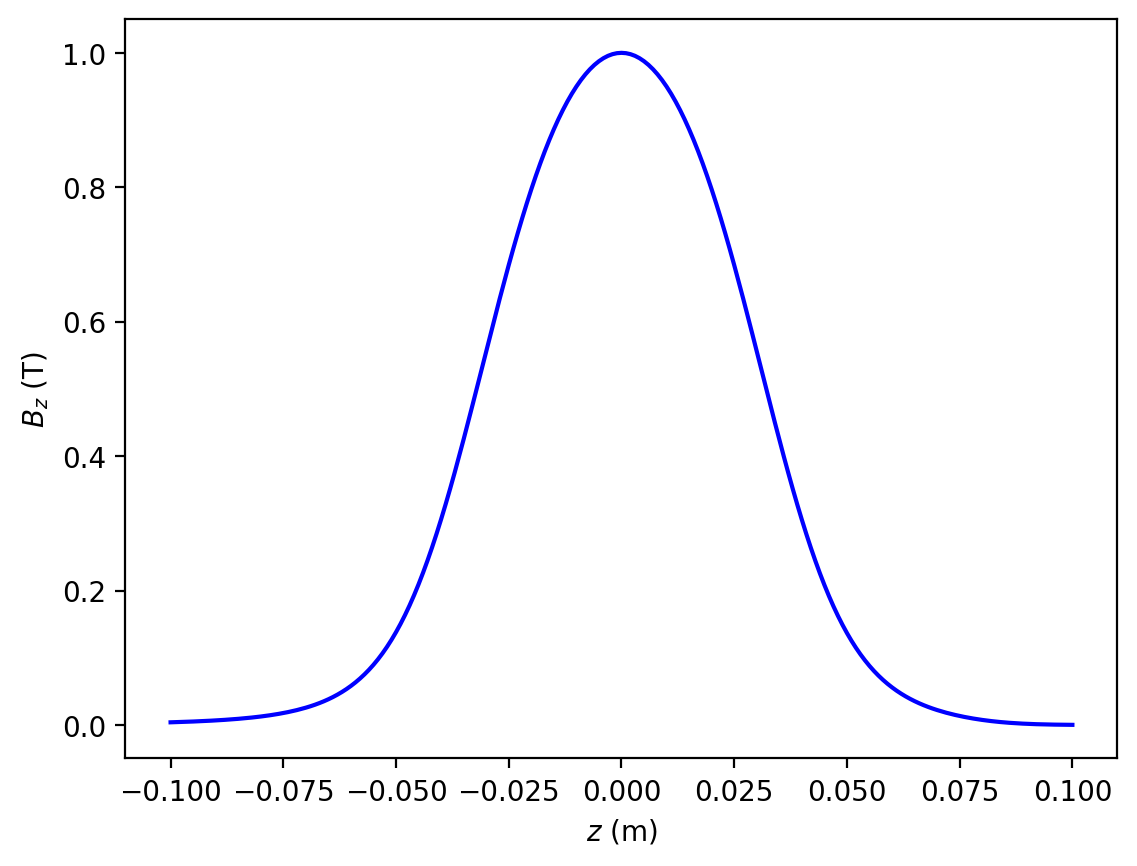

In [4]:
FM.plot_onaxis()

Off-axis plotting can be done with the `axis_values` method to get interpolated values, and manually plot:

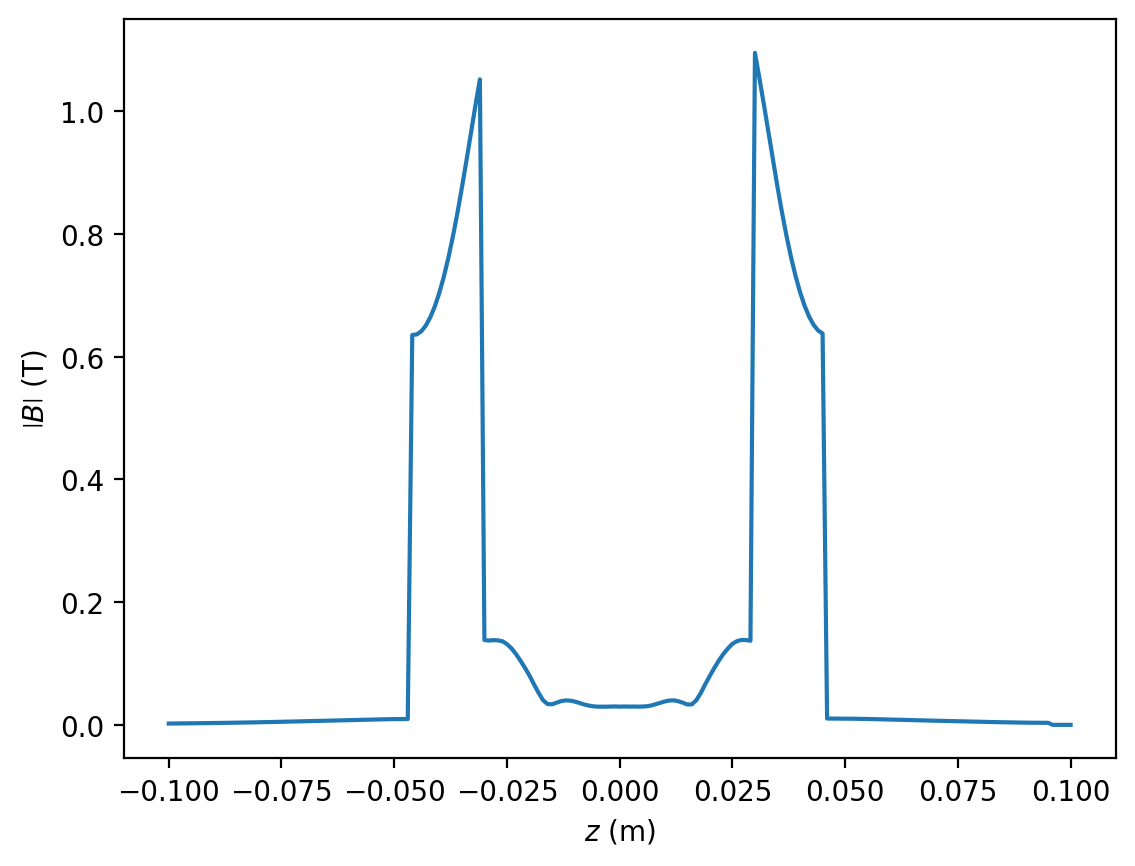

In [5]:
z, Bz = FM.axis_values('z', 'abs_B', r=0.04)
plt.plot(z, Bz)
plt.xlabel(r'$z$ (m)')
plt.ylabel(r'$\left|B\right|$ (T)')
plt.show()

# Interpolation

Arbirtrary points can also be interpolated. Here is the value of $B_z$ at `r=0.01`, `theta=0`, `z=0`:

In [6]:
FM.interpolate('Bz', (0.01,0,0) )

np.float64(1.0246914678449792)

In [7]:
FM.interpolate('Bz', [(0,0,z) for z in np.linspace(-.1, .1, 3)] )

array([4.10454985e-03, 1.00000000e+00, 3.31380794e-04])

Note that the points are orderd by the axis labels:

In [8]:
FM.axis_labels

('r', 'theta', 'z')

# Internal data

attributes and components

In [9]:
FM.attrs, FM.components.keys()

({'eleAnchorPt': 'beginning',
  'gridGeometry': 'cylindrical',
  'axisLabels': array(['r', 'theta', 'z'], dtype='<U5'),
  'gridLowerBound': array([0, 1, 0]),
  'gridOriginOffset': array([ 0. ,  0. , -0.1]),
  'gridSpacing': array([0.001, 0.   , 0.001]),
  'gridSize': array([101,   1, 201]),
  'harmonic': np.int64(0),
  'fundamentalFrequency': np.int64(0),
  'RFphase': 0,
  'fieldScale': 1.0},
 dict_keys(['magneticField/z', 'magneticField/r']))

# Properties

Convenient access to these

In [10]:
FM.shape

(np.int64(101), np.int64(1), np.int64(201))

In [11]:
FM.frequency

0

Coordinate vectors: `.r`, `.theta`, `.z`, etc.

In [12]:
FM.r, FM.dr

(array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
        0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
        0.018, 0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026,
        0.027, 0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035,
        0.036, 0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044,
        0.045, 0.046, 0.047, 0.048, 0.049, 0.05 , 0.051, 0.052, 0.053,
        0.054, 0.055, 0.056, 0.057, 0.058, 0.059, 0.06 , 0.061, 0.062,
        0.063, 0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07 , 0.071,
        0.072, 0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08 ,
        0.081, 0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089,
        0.09 , 0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098,
        0.099, 0.1  ]),
 np.float64(0.001))

Grid info

In [13]:
FM.mins, FM.maxs, FM.deltas

(array([ 0. ,  0. , -0.1]),
 array([0.1, 0. , 0.1]),
 array([0.001, 0.   , 0.001]))

Convenient logicals

In [14]:
FM.is_static, FM.is_pure_magnetic, FM.is_pure_magnetic,  FM.is_pure_electric

(np.True_, True, True, False)

# Components

In [15]:
FM.components

{'magneticField/z': array([[[ 4.10454985e-03,  4.31040451e-03,  4.52986744e-03, ...,
           4.67468517e-04,  3.93505841e-04,  3.31380794e-04]],
 
        [[ 4.10132316e-03,  4.30698128e-03,  4.52613784e-03, ...,
           4.63910019e-04,  3.90463457e-04,  3.28826095e-04]],
 
        [[ 4.09178241e-03,  4.29666227e-03,  4.51500745e-03, ...,
           4.53304832e-04,  3.81497195e-04,  3.21252672e-04]],
 
        ...,
 
        [[-8.55276742e-05, -9.25454620e-05, -9.97134392e-05, ...,
          -1.67910069e-13, -1.66617291e-13, -1.69112101e-13]],
 
        [[-8.66606075e-05, -9.34605759e-05, -1.00393739e-04, ...,
          -1.63746446e-13, -1.62385457e-13, -1.63975660e-13]],
 
        [[-8.76493773e-05, -9.42325632e-05, -1.00947206e-04, ...,
          -1.59165583e-13, -1.57653026e-13, -1.58633209e-13]]]),
 'magneticField/r': array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],
 
        [[-9.96833640e-05, -1.

Convenient access to component data

In [16]:
FM.Bz is FM['magneticField/z']

True

Setting .scale will set the underlying attribute

In [17]:
FM.scale = 2
FM.attrs['fieldScale'], FM.scale

(2, 2)

Raw components accessed by their full key

In [18]:
FM['magneticField/z']

array([[[ 4.10454985e-03,  4.31040451e-03,  4.52986744e-03, ...,
          4.67468517e-04,  3.93505841e-04,  3.31380794e-04]],

       [[ 4.10132316e-03,  4.30698128e-03,  4.52613784e-03, ...,
          4.63910019e-04,  3.90463457e-04,  3.28826095e-04]],

       [[ 4.09178241e-03,  4.29666227e-03,  4.51500745e-03, ...,
          4.53304832e-04,  3.81497195e-04,  3.21252672e-04]],

       ...,

       [[-8.55276742e-05, -9.25454620e-05, -9.97134392e-05, ...,
         -1.67910069e-13, -1.66617291e-13, -1.69112101e-13]],

       [[-8.66606075e-05, -9.34605759e-05, -1.00393739e-04, ...,
         -1.63746446e-13, -1.62385457e-13, -1.63975660e-13]],

       [[-8.76493773e-05, -9.42325632e-05, -1.00947206e-04, ...,
         -1.59165583e-13, -1.57653026e-13, -1.58633209e-13]]])

Scaled component accessed by shorter keys, e.g. 

In [19]:
FM['Bz']

array([[[ 8.20909970e-03,  8.62080901e-03,  9.05973488e-03, ...,
          9.34937033e-04,  7.87011682e-04,  6.62761588e-04]],

       [[ 8.20264631e-03,  8.61396257e-03,  9.05227569e-03, ...,
          9.27820038e-04,  7.80926913e-04,  6.57652189e-04]],

       [[ 8.18356483e-03,  8.59332454e-03,  9.03001490e-03, ...,
          9.06609663e-04,  7.62994390e-04,  6.42505344e-04]],

       ...,

       [[-1.71055348e-04, -1.85090924e-04, -1.99426878e-04, ...,
         -3.35820138e-13, -3.33234581e-13, -3.38224202e-13]],

       [[-1.73321215e-04, -1.86921152e-04, -2.00787478e-04, ...,
         -3.27492892e-13, -3.24770914e-13, -3.27951319e-13]],

       [[-1.75298755e-04, -1.88465126e-04, -2.01894411e-04, ...,
         -3.18331166e-13, -3.15306051e-13, -3.17266417e-13]]])

In [20]:
FM['magneticField/z'].max(), FM['Bz'].max()

(np.float64(2.150106838829148), np.float64(4.300213677658296))

# Oscillating fields

Oscillating fields have `.harmonic > 0`

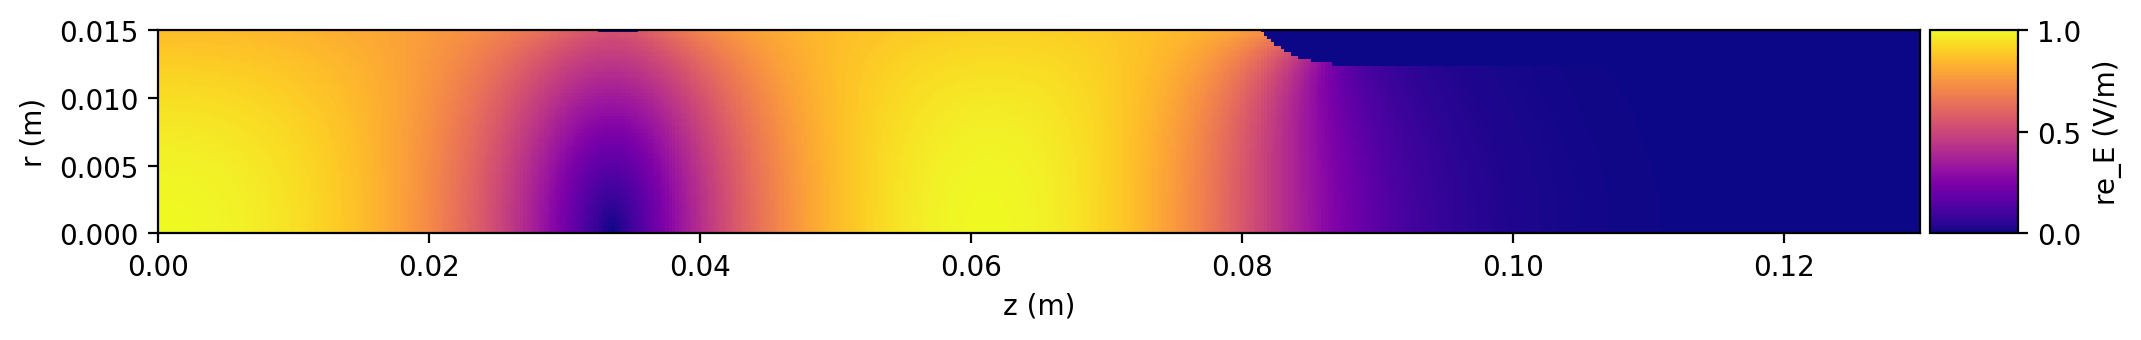

In [21]:
FM = FieldMesh('../data/rfgun.h5')
FM.plot('re_E', aspect='equal', figsize=(12,4))

The magnetic field is out of phase, so use the `im_` syntax:

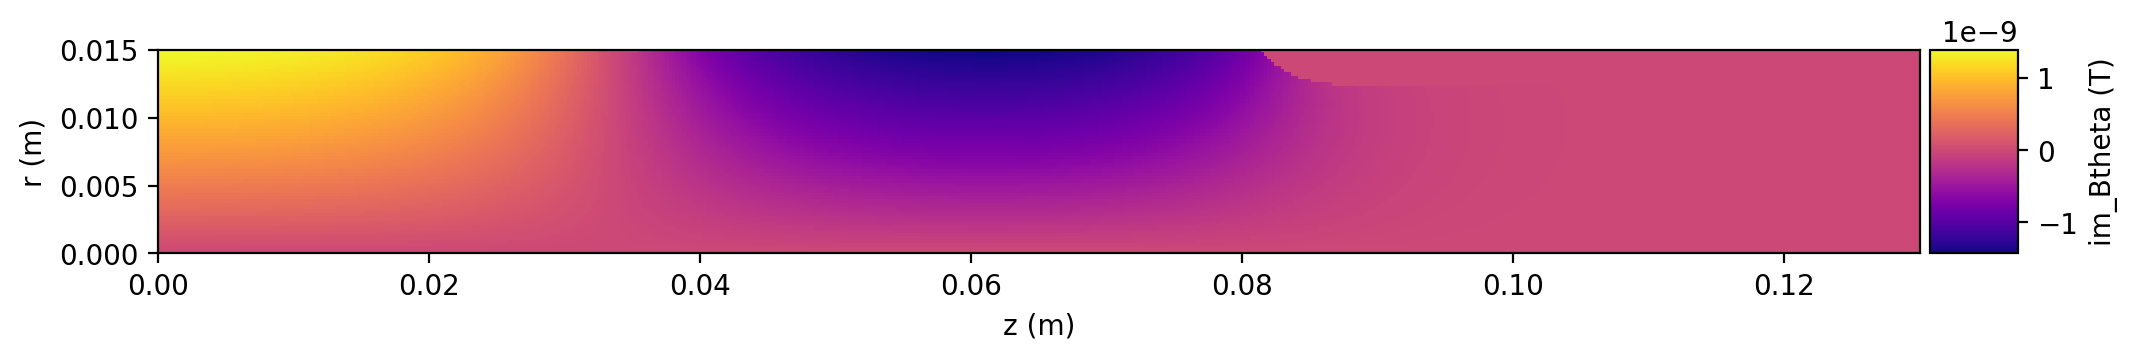

In [22]:
FM.plot('im_Btheta', aspect='equal', figsize=(12,4))

Max on-axis field:

In [23]:
np.abs(FM.Ez[0,0,:]).max()

np.float64(1.0)

## Verify the oscillation

Complex fields oscillate as $e^{-i\omega t}$. For TM fields, the spatial components $E_z$ and $B_\theta$ near the axis 

$\Re E_{z} = -\frac{r}{2}\frac{\omega}{c^2} \Im B_\theta$


Text(0.5, 1.0, 'Complex field oscillation')

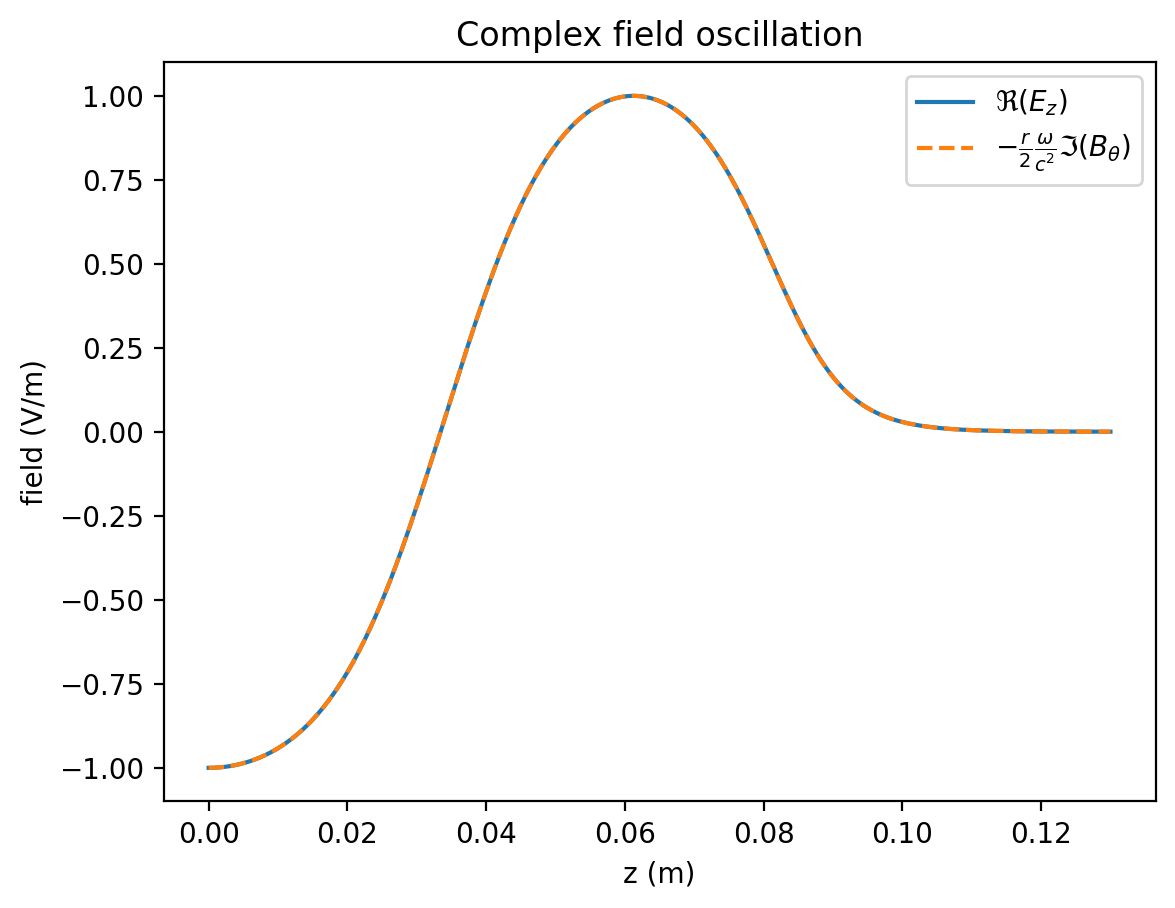

In [24]:
c_light = 299792458.

dr = FM.dr
omega = FM.frequency*2*np.pi

# Check the first off-axis grid points
z0 = FM.z
Ez0 = np.real(FM.Ez[0,0,:])
B1 = -np.imag(FM.Btheta[1,0,:])

plt.plot(z0, Ez0, label=r'$\Re \left( E_z\right)$')
plt.plot(z0, B1*2/dr *c_light**2/omega, '--', label=r'$-\frac{r}{2}\frac{\omega}{c^2} \Im\left(B_\theta\right)$')
plt.ylabel('field (V/m)')
plt.xlabel('z (m)')
plt.legend()
plt.title(r'Complex field oscillation')

# Units

In [25]:
FM.units('Bz')

pmd_unit('T', 1, (0, 1, -2, -1, 0, 0, 0))

This also works:

In [26]:
FM.units('abs_Ez')

pmd_unit('V/m', 1, (1, 1, -3, -1, 0, 0, 0))

# Write

In [27]:
FM.write('rfgun2.h5')

Read back and make sure the data are the same.

In [28]:
FM2 = FieldMesh('rfgun2.h5')

assert FM == FM2

Write to open HDF5 file and test reload:

In [29]:
import h5py
with h5py.File('test.h5', 'w') as h5:
    FM.write(h5, name='myfield')
    FM2 = FieldMesh(h5=h5['myfield'])
    assert FM == FM2

## Write Astra 1D

Astra primarily uses simple 1D (on-axis) fieldmaps.

In [30]:
FM.write_astra_1d('astra_1d.dat')

Another method returns the array data with some annotation

In [31]:
FM.to_astra_1d()

{'attrs': {'type': 'astra_1d'},
 'data': array([[ 0.00000000e+00, -1.00000000e+00],
        [ 2.50000000e-04, -9.99967412e-01],
        [ 5.00000000e-04, -9.99865106e-01],
        ...,
        [ 1.29500000e-01,  1.45678834e-04],
        [ 1.29750000e-01,  1.40392476e-04],
        [ 1.30000000e-01,  1.35399670e-04]])}

## Write Impact-T 

Impact-T uses a particular Fourier representation for 1D fields. These routines form this data.

In [32]:
idata = FM.to_impact_solrf()
idata.keys()

dict_keys(['line', 'rfdata', 'ele', 'fmap'])

This is an element that can be used with LUME-Impact

In [33]:
idata['ele']

{'L': np.float64(0.13),
 'type': 'solrf',
 'zedge': np.int64(0),
 'rf_field_scale': np.int64(1),
 'rf_frequency': np.float64(2855998506.158),
 'theta0_deg': 0.0,
 'filename': 'rfdata666',
 'radius': 0.15,
 'x_offset': 0,
 'y_offset': 0,
 'x_rotation': 0.0,
 'y_rotation': 0.0,
 'z_rotation': 0.0,
 'solenoid_field_scale': np.int64(0),
 'name': 'solrf_666',
 's': np.float64(0.13)}

This is a line that would be used 

In [34]:
 idata['line']

'0.13 0 0 105 0 1 2855998506.158 0.0 666 0.15 0 0 0 0 0 0 /name:solrf_666'

Data that would be written to the rfdata999 file

In [35]:
idata['rfdata']

array([ 5.90000000e+01, -1.30000000e-01,  1.30000000e-01,  2.60000000e-01,
        2.38794165e-01, -3.04717859e-01, -3.56926831e-17, -7.49524991e-01,
        7.32463833e-18, -2.59757413e-01, -4.86268193e-17,  1.27535902e-01,
       -7.69533405e-17,  4.49651550e-02, -1.49248909e-16,  4.67567146e-03,
       -1.74265243e-16,  3.32025307e-02,  6.08199268e-17, -2.74904837e-03,
        1.81697659e-16, -1.55710320e-02, -1.52414246e-16,  2.64475111e-03,
       -1.34254267e-16,  9.51814907e-04,  2.55576008e-16, -2.68547441e-03,
        4.07106499e-16,  1.50824509e-03,  3.51376926e-16,  7.16574075e-04,
        1.71392948e-16, -9.25573616e-04, -1.31642032e-16,  2.40084183e-04,
       -1.26211536e-16,  2.61495768e-04,  1.88301027e-16, -2.41687337e-04,
       -1.66678067e-17,  6.22859548e-05, -3.05911380e-16,  7.85163760e-05,
       -2.60061418e-16, -8.56926328e-05, -2.58448920e-16,  2.38418521e-06,
       -2.89297721e-16,  2.84696849e-05, -1.77699805e-16, -2.10693774e-05,
       -1.20356079e-17,  

This is the fieldmap that makes that data:

In [36]:
fmap = idata['fmap']
fmap.keys()

dict_keys(['info', 'data', 'field'])

Additional info:

In [37]:
fmap['info']

{'format': 'solrf',
 'Ez_scale': np.float64(1.0),
 'Ez_err': np.float64(7.685886302958377e-08),
 'Bz_scale': np.float64(0.0),
 'Bz_err': 0,
 'zmin': np.float64(-0.13),
 'zmax': np.float64(0.13)}

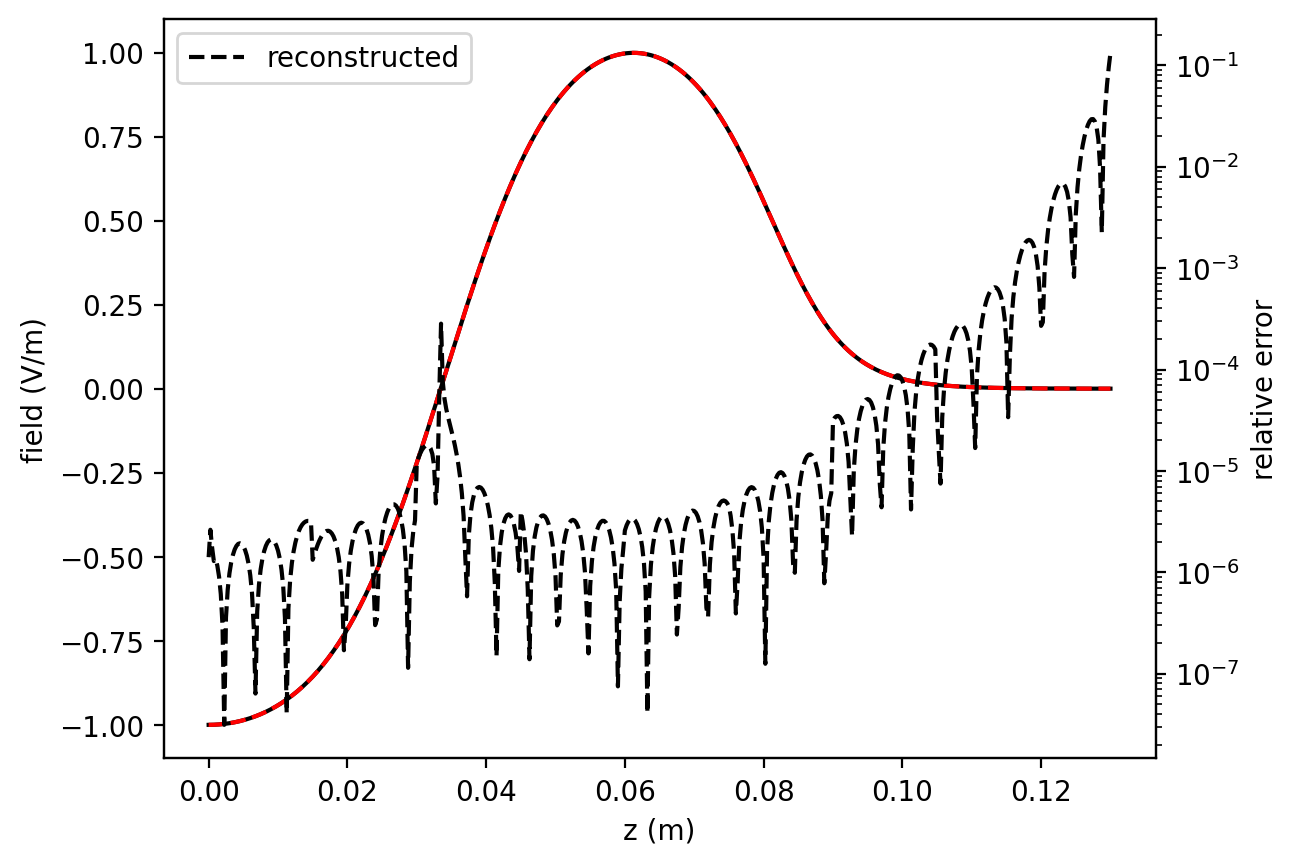

In [38]:
from pmd_beamphysics.interfaces.impact import fourier_field_reconsruction
L = np.ptp(z0)
zlist = np.linspace(0, L, len(Ez0))
fcoefs = fmap['field']['Ez']['fourier_coefficients']
reconstructed_Ez0 = np.array([fourier_field_reconsruction(z, fcoefs, z0=-L, zlen = 2*L) for z in zlist])

fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(z0, Ez0, label=r'$\Re \left( E_z\right)$', color='black')
ax.plot(zlist, reconstructed_Ez0, '--',  label='reconstructed', color='red', )
ax2.plot(zlist, abs(reconstructed_Ez0/Ez0 -1), '--',  label='reconstructed', color='black' )
ax2.set_ylabel('relative error')
ax2.set_yscale('log')
ax.set_ylabel('field (V/m)')
ax.set_xlabel('z (m)')
plt.legend()

This function can also be used to study the reconstruction error as a function of the number of coefficients:

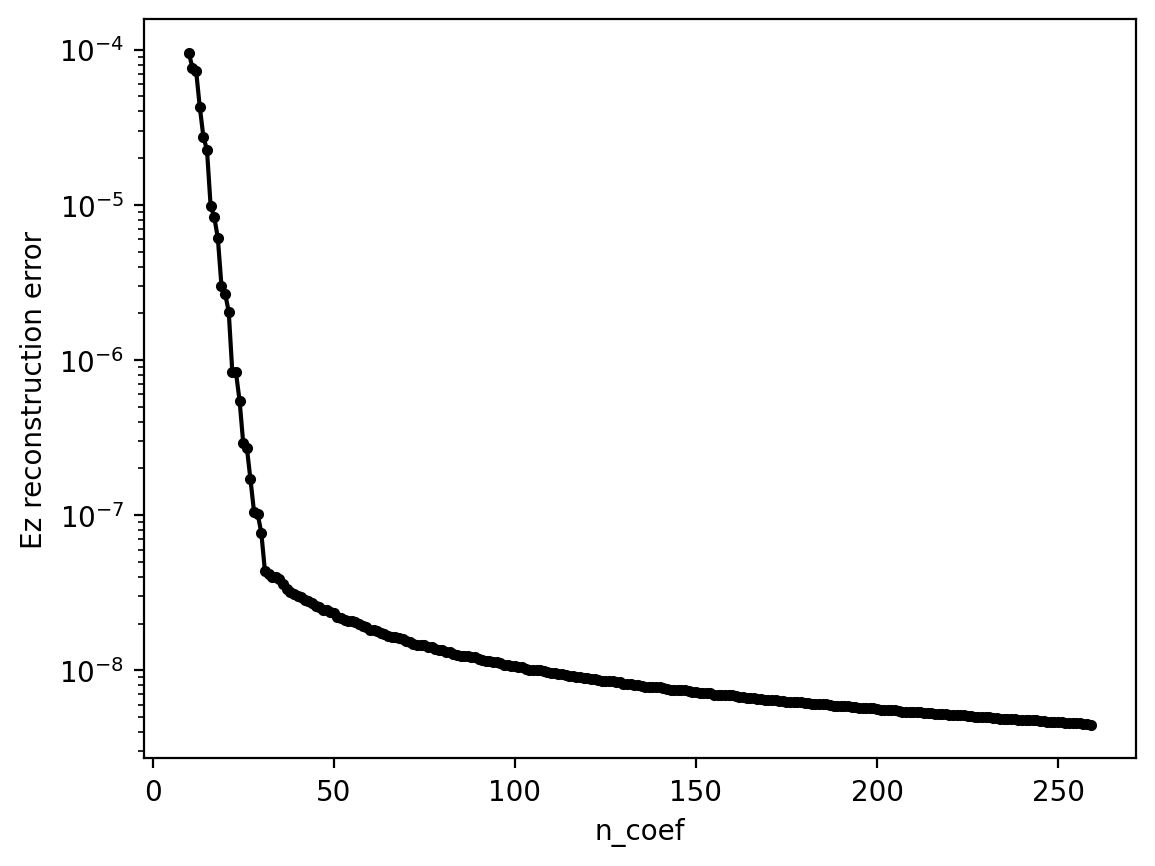

In [39]:
ncoefs = np.arange(10, FM2.shape[2]//2)
errs = np.array([FM2.to_impact_solrf(n_coef = n, zmirror=True)['fmap']['info']['Ez_err'] for n in ncoefs])

fig, ax = plt.subplots()
ax.plot(ncoefs, errs, marker='.', color='black')
ax.set_xlabel('n_coef')
ax.set_ylabel('Ez reconstruction error')
ax.set_yscale('log')

## Write GPT

In [40]:
#FM.write_gpt('solenoid.gdf', asci2gdf_bin='$ASCI2GDF_BIN', verbose=True)
FM.write_gpt('rfgun_for_gpt.txt', verbose=True)

ASCII field data written. Convert to GDF using: asci2df -o field.gdf rfgun_for_gpt.txt


'rfgun_for_gpt.txt'

In [41]:
FM.write_superfish('rfgun2.t7')

'rfgun2.t7'

# Read Superfish

Proper Superfish T7 can also be read.

In [42]:
FM3 = FieldMesh.from_superfish('rfgun2.t7')
FM3

<FieldMesh with cylindrical geometry and (61, 1, 521) shape at 0x156e93c20>

In [43]:
help(FieldMesh.from_superfish)

Help on method read_superfish_t7 in module pmd_beamphysics.interfaces.superfish:

read_superfish_t7(type=None, geometry='cylindrical') class method of pmd_beamphysics.fields.fieldmesh.FieldMesh
    Parses a T7 file written by Posson/Superfish.

    Fish or Poisson T7 are automatically detected according to the second line.

    For Poisson problems, the type must be specified.

    Superfish fields oscillate as:
        Er, Ez ~ cos(wt)
        Hphi   ~ -sin(wt)

    For complex fields oscillating as e^-iwt

        Re(Ex*e^-iwt)   ~ cos
        Re(-iB*e^-iwt) ~ -sin
    and therefore B = -i * mu_0 * H_phi is the complex magnetic field in Tesla


    Parameters:
    ----------
    filename: str
        T7 filename to read
    type: str, optional
        For Poisson files, required to be 'electric' or 'magnetic'.
        Not used for Fish files
    geometry: str, optional
        field geometry, currently required to be the default: 'cylindrical'

    Returns:
    -------
    fieldmesh_

Note that writing the ASCII and conversions alter the data slightly

In [44]:
FM == FM3

False

But the data are all close:

In [45]:
for c in FM.components:
    close = np.allclose(FM.components[c], FM3.components[c])
    equal = np.all(FM.components[c] == FM3.components[c])
    print(c, equal, close)

electricField/z False True
electricField/r False True
magneticField/theta False True


## Read ANSYS

Read ANSYS E and H ASCII files:

In [46]:
FM3D = FieldMesh.from_ansys_ascii_3d(efile='../data/ansys_rfgun_2856MHz_E.dat',
                              hfile='../data/ansys_rfgun_2856MHz_H.dat',
                              frequency=2856e6)



FM3D

<FieldMesh with rectangular geometry and (3, 3, 457) shape at 0x157109bb0>

In [47]:
FM3D.attrs

{'eleAnchorPt': 'beginning',
 'gridGeometry': 'rectangular',
 'axisLabels': ('x', 'y', 'z'),
 'gridLowerBound': (0, 0, 0),
 'gridOriginOffset': (np.float64(-0.001), np.float64(-0.001), np.float64(0.0)),
 'gridSpacing': (np.float64(0.001), np.float64(0.001), np.float64(0.00025)),
 'gridSize': (3, 3, 457),
 'harmonic': 1,
 'fundamentalFrequency': 2856000000.0,
 'RFphase': 0,
 'fieldScale': 1.0}

This can then be written:

In [48]:
FM3D.write('../data/rfgun_rectangular.h5')

The y=0 plane can be extracted to be used as cylindrically symmetric data:

In [49]:
 FM2D = FM3D.to_cylindrical()
FM2D

<FieldMesh with cylindrical geometry and (2, 1, 457) shape at 0x156e72f60>

# Cleanup

In [50]:
import os
for file in ('test.h5',
             'astra_1d.dat',
             'rfgun_for_gpt.txt',
             'rfgun2.h5',
             'rfgun2.t7'):
    os.remove(file)
